In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from stardist import fill_label_holes, random_label_cmap

np.random.seed(42)
#lbl_cmap = random_label_cmap()

Using TensorFlow backend.


# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
In general, training data (for input `X` with associated labels `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.

In [2]:
X = sorted(glob('data/dsb2018/train/images/*.tif'))
Y = sorted(glob('data/dsb2018/train/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Normalize images and fill small label holes.

In [4]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 447/447 [00:02<00:00, 163.63it/s]


In [5]:
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = int(round(0.15 * len(X)))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i][:256,:256,np.newaxis] for i in ind_val]  , [Y[i][:256,:256,np.newaxis] for i in ind_val]
X_trn, Y_trn = [X[i][:256,:256,np.newaxis] for i in ind_train], [Y[i][:256,:256,np.newaxis] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))



number of images: 447
- training:       380
- validation:      67


In [6]:
#https://segmentation-models.readthedocs.io/en/latest/tutorial.html
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.utils import multi_gpu_model

BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

# load your data
x_train = np.stack(X_trn,axis=0)
y_train = np.stack(Y_trn,axis=0)
x_val = np.stack(X_val,axis=0)
y_val = np.stack(Y_val,axis=0)

/home/steinbac/.local/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [7]:
# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
#base_model = Unet(BACKBONE, encoder_weights='imagenet')

# mitigating greyscale images
#inp = Input(shape=(None, None, 1))
#l1 = Conv2D(3, (1, 1))(inp) # map 1 channel onto 3 channels through a conv with 1x1 and 3 filters
#out = base_model(l1)

#kmodel = Model(inp, out, name=base_model.name)
#kmodel = multi_gpu_model(model, gpus=2)
kmodel = Unet(BACKBONE, encoder_weights=None, input_shape=(None, None, 1))

kmodel.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])
print(kmodel.output)

Instructions for updating:
Colocations handled automatically by placer.
Tensor("sigmoid/Sigmoid:0", shape=(?, ?, ?, 1), dtype=float32)


In [8]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
kmodel.fit(
    x=x_train,
    y=y_train,
    batch_size=16,
    epochs=100,
    validation_data=(x_val, y_val),
)

Instructions for updating:
Use tf.cast instead.
Train on 380 samples, validate on 67 samples
Epoch 1/100
380/380 [==============================] - 15s 40ms/step - loss: -36.6691 - iou_score: 5.4496 - val_loss: -32.2675 - val_iou_score: 5.3210
Epoch 2/100
380/380 [==============================] - 4s 11ms/step - loss: -60.5825 - iou_score: 7.3446 - val_loss: -44.4255 - val_iou_score: 5.5920
Epoch 3/100
380/380 [==============================] - 4s 11ms/step - loss: -68.9981 - iou_score: 8.7154 - val_loss: -44.8168 - val_iou_score: 5.7002
Epoch 4/100
380/380 [==============================] - 4s 12ms/step - loss: -70.8210 - iou_score: 9.8693 - val_loss: -36.2611 - val_iou_score: 5.4447
Epoch 5/100
380/380 [==============================] - 4s 12ms/step - loss: -72.2254 - iou_score: 10.8508 - val_loss: -33.0096 - val_iou_score: 4.0414
Epoch 6/100
380/380 [==============================] - 4s 12ms/step - loss: -72.6018 - iou_score: 11.3443 - val_loss: -34.1758 - val_iou_score: 3.8251
Epoc

(256, 256) float32 -0.022727273 1.2045455
(256, 256)


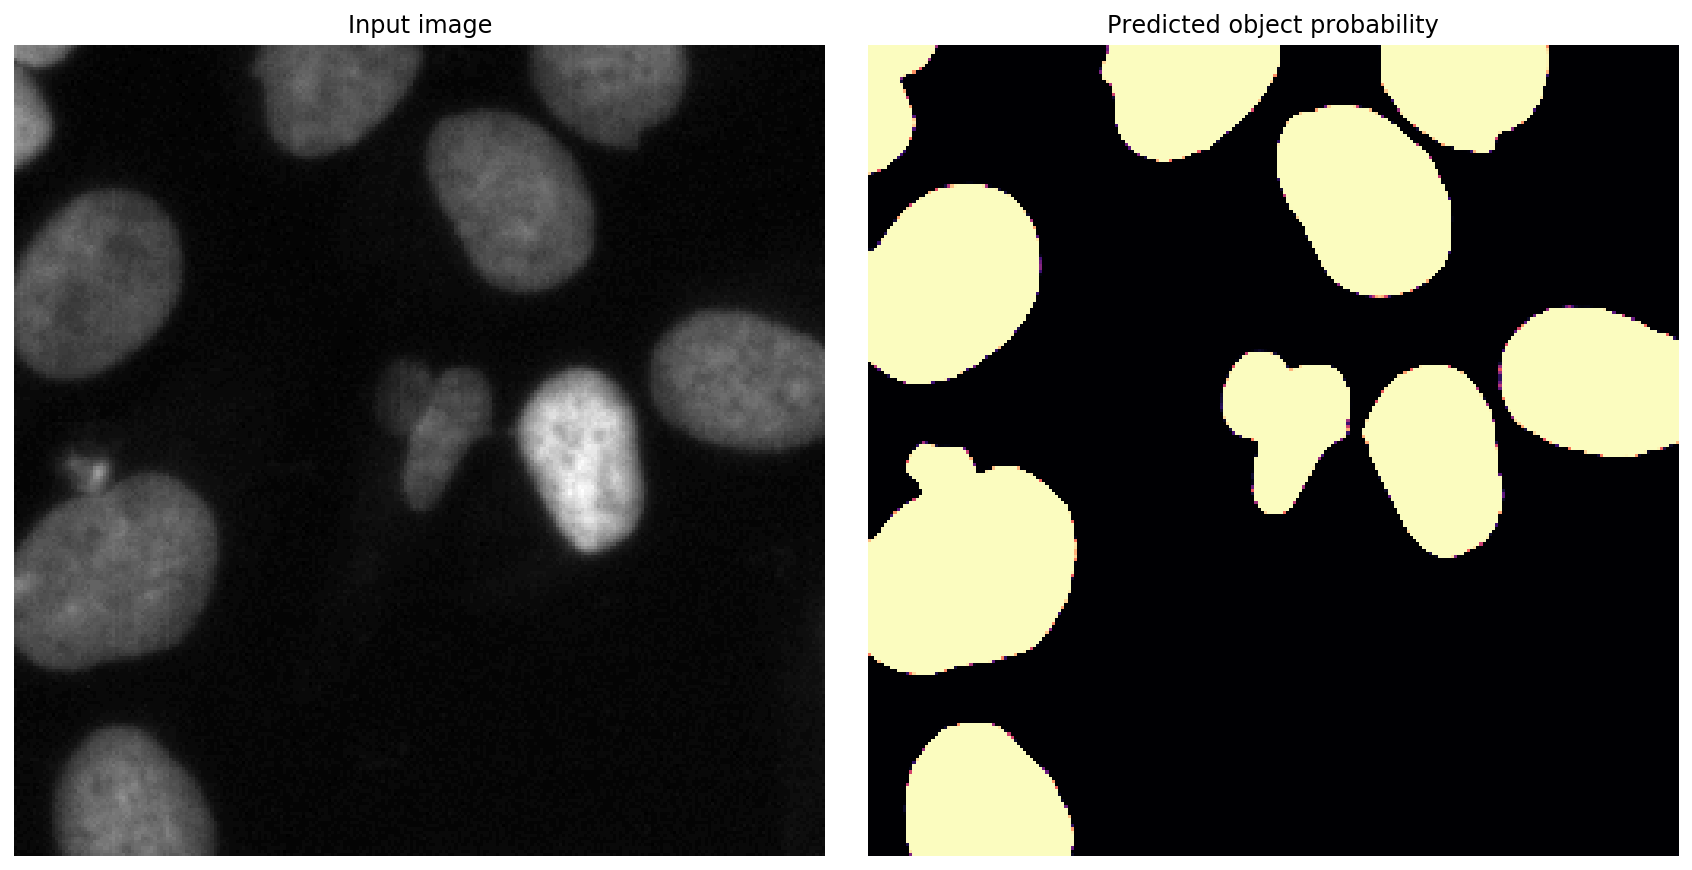

In [9]:
inim = X[42][:256,:256]
print(inim.shape,inim.dtype,np.min(inim),np.max(inim))
img=X[42][np.newaxis,:256,:256,np.newaxis]
pred = kmodel.predict(img)[0,:,:,0]
print(pred.shape)

fig, ax = plt.subplots(1,2, figsize=(12,6))

for a,d,cm,s in zip(ax.flat, [inim,pred], ['gray','magma'],
                    ['Input image','Predicted object probability']):
    a.imshow(d,cmap=cm)
    a.set_title(s)
    a.axis('off')
plt.tight_layout()
None;

In [10]:
from foolbox.models import KerasModel


fmodel = KerasModel(kmodel,bounds=(-1., 2.))



ValueError: too many values to unpack (expected 2)

In [ ]:
from foolbox.criteria import Criterion 
import math

class Missegmentation(Criterion):
    """Defines adversarials as inputs for which the predicted class
    is not the original class.
    See Also
    --------
    :class:`TopKMisclassification`
    Notes
    -----
    Uses `numpy.argmax` to break ties.
    """
    def __init__(self, cut=1e-5):
        super(Missegmentation, self).__init__()
        assert cut > 0
        self.t = cut
        
    def name(self):
        return 'Top1Missegmentation'

    #def is_adversarial(self, predictions, label):
    #    top1 = np.argmax(predictions)
    #    return top1 != label
    def is_adversarial(self, predictions, label):
        l2 = np.sum((pred-label)**2)
        return math.sqrt(l2) > self.t
    

In [ ]:
#base_model.summary()
kmodel.summary()

In [ ]:
from foolbox.adversarial import Adversarial
from foolbox.attacks import SinglePixelAttack
from IPython.core.debugger import set_trace

#lab = Y[42][np.newaxis,:256,:256,np.newaxis]
inp = x_val[42]
lab = y_val[42]
print(lab.shape,inp.shape)
print("+"*50)

attack = SinglePixelAttack()
criterion = Missegmentation()
set_trace()
adversarial = Adversarial(fmodel, criterion, inp, lab)

fpred = attack(adversarial)